# Tutorial: How to run errro mitigated state reconstruction.

## Import files and libraries

In [1]:
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from EMQST_lib import unit_test as ut
from EMQST_lib import support_functions as sf
from EMQST_lib import emqst
from EMQST_lib.qst import QST  
from EMQST_lib.povm import POVM

Define operational parameters for the simulation and error mitigation.

In [2]:
bool_exp_measurements = False # Whether to call experimental sampling function or not
n_qubits = 1 # Currently only supports 1 qubit.  
n_QST_shots = 10**4 # Number of shots for each spin measurement pr true state (total=3*n_QST_shots nativly)
n_calibration_shots = 10**5 # Calibration shots for DT, each calibration state and each spin measurment
n_cores = 4 # Available cores for 
n_averages = 5 # Only used if you generate true states generate_random_pure_state()


noise_mode = 2 # Noise mode if using synthetic measurement
# 0: No noise
# 1: Depolarizing noise
# 2: Stronger depolarized noise
# 3: Amplitude damping
# 4: Constant rotation around x-axis


# Example of how to take in angles and convert them to to true states.
list_of_true_angles = np.array([[np.pi/2,0],[np.pi/2,np.pi],
                        [np.pi/2,np.pi/2],[np.pi/2,3*np.pi/2],
                        [0,0],[np.pi,0]])

list_of_true_states = np.array([sf.get_projector_from_angles(np.array([angles])) for angles in list_of_true_angles])


# Alternativly you can generate states using the built in random pure state generator.
list_of_true_states = np.array([sf.generate_random_pure_state(n_qubits) for _ in range(n_averages)])


# Optionally you can also defined calibration states used for DT, default is all Pauli states
calibration_angles = np.array([[[np.pi/2,0]],[[np.pi/2,np.pi]],
                            [[np.pi/2,np.pi/2]],[[np.pi/2,3*np.pi/2]],
                            [[0,0]],[[np.pi,0]]])
calibration_states = np.array([sf.get_density_matrix_from_angles(angle) for angle in calibration_angles])


# If you want to connect your own experiment, you need to define a measurement function
# and supply it with the experimental dictionary. The experimetnal dictionary will be passed
# to the experimental measurement function, which should contain all parameters required to run
# the experiment.

# Example of the experimental measurement function.
 
def exp_measurement_function(n_shots,POVM_angles,true_state_angles,exp_dictionary):
    print(exp_dictionary)
    """
    It takes in:
    - n_shots as an int
    - POVM_angles (spin measuremnt angles in the Bloch sphere) 
    as np array [ [ [theta,phi], [orthogonal angles] ] ]
    - true state angles as np array [ [theta,phi] ]

    return: 
    np array with index 0 outcomes corresponding to first set of POVM angels and 1 for the second set of POVM angles. 
    e.g. [1,0,0,1,1,0,0,0,...]
    """
    return np.random.randint(low=0,high=2,size=(n_shots))

# All experimental parametres needed should be added to the experimetnal dictionary. 
exp_dictionary = {"measurement_function": exp_measurement_function }


Running the default simulation.

Created results dictionary.
----------------------------
Error corrected BME.
600000 POVM calibration shots.
30000 QST shots.
5 QST averages.
----------------------------
Synthetic noise mode 2.
	Number of MLE iterations: 50, final distance 3.56548124358369e-13
	Number of MLE iterations: 50, final distance 8.68222160832488e-13
	Number of MLE iterations: 50, final distance 2.498001805406602e-16
Runtime of DT reconstruction 0.19598984718322754
Distance between reconstructed and noisy POVM: 0.0018273086364194724
Distance between reconstructed and noisy POVM: 0.0023765358601076925
Distance between reconstructed and noisy POVM: 0.0036263634596080396
POVM calibration complete.
----------------------------
Generated data.
Start corrected QST.
Completed run 1/5. Final infidelity: 0.004514030604771624.
Completed run 2/5. Final infidelity: 0.002880494520924204.
Completed run 3/5. Final infidelity: 0.00746971907713434.
Completed run 4/5. Final infidelity: 0.0026827104970231774.
Completed run 5/5.

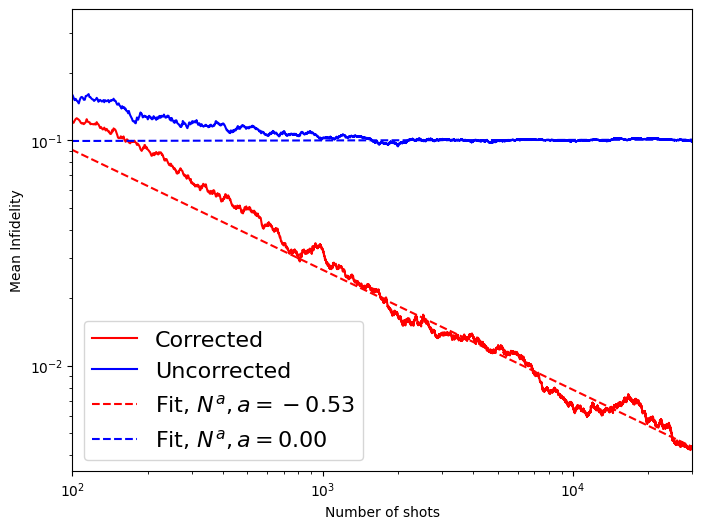

In [3]:
# Calling the error mitigated QST. The function returns the set of mitigated and unmitigated infidelities
# for comparison. It alo supplies the list of error mitigated state estimates.
# In addition all run parameters are saved to a files in result.
uncorrected_infidelity, corrected_infidelity,rho_estm = emqst.emqst(n_qubits,n_QST_shots,n_calibration_shots,
                                                            list_of_true_states,bool_exp_measurements=bool_exp_measurements,
                                                            calibration_states=calibration_states,exp_dictionary=exp_dictionary,
                                                            n_cores=n_cores, noise_mode=noise_mode)
print(uncorrected_infidelity)
print(corrected_infidelity)

Example of simulating data and running QST: 

Start generating data.
Start QST.
Completed run 1/5. Final infidelity: 0.002140797441857467.
Completed run 2/5. Final infidelity: 0.0035715092433860063.
Completed run 3/5. Final infidelity: 0.008403156972041304.
Completed run 4/5. Final infidelity: 0.004099924426759771.
Completed run 5/5. Final infidelity: 0.003246079724645412.
[[0.38123218 0.3217423  0.31626987 ... 0.00214537 0.00214135 0.0021408 ]
 [0.45007182 0.38054757 0.34052491 ... 0.00357414 0.00357168 0.00357151]
 [0.45633627 0.42159413 0.38990018 ... 0.00842968 0.00841817 0.00840316]
 [0.46463242 0.3908033  0.37020596 ... 0.00411434 0.00410616 0.00409992]
 [0.4414697  0.50029159 0.43934375 ... 0.00323735 0.0032498  0.00324608]]


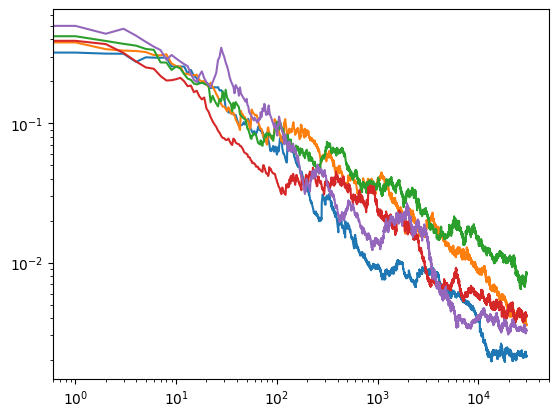

In [8]:
# Basic QST example
# We use a different POVM object, using pauli-6 looks like this
n_qubits=1
POVM_list=POVM.generate_Pauli_POVM(n_qubits)

# Define the estimator
qst=QST(POVM_list,list_of_true_states,n_QST_shots,1,bool_exp_measurements,exp_dictionary,n_cores=n_cores)

print("Start generating data.")
qst.generate_data()


print("Start QST.")
qst.perform_BME()
rho_estm=qst.get_rho_estm()
infidelity=qst.get_infidelity()
print(infidelity)
for i in range (len(infidelity)):
    plt.plot(infidelity[i])
plt.yscale('log')
plt.xscale('log')
plt.show()



### Loading data and perform experiments again. 

Example of loading data from the QST_settings.npy
QST_settings contain the current working state of the QST class, which includes the data gathered, POVM reconstruction, resulting state reconstruction, shot by shot infidelities for both corrected and uncorrected reconstructions. 

Loaded QST settings from results/2023-12-01_11-32-15_a1982a66-4157-4e19-92a0-01604bb3b317/
Completed run 1/5. Final infidelity: 0.001955820515143092.
Completed run 2/5. Final infidelity: 0.0022101417696598347.
Completed run 3/5. Final infidelity: 0.0030173064882488276.
Completed run 4/5. Final infidelity: 0.008603452819664015.
Completed run 5/5. Final infidelity: 0.0024755943191250296.
Completed run 1/5. Final infidelity: 0.0016434212143887628.
Completed run 2/5. Final infidelity: 0.0034519433673005917.
Completed run 3/5. Final infidelity: 0.002639535379878377.
Completed run 4/5. Final infidelity: 0.004321753035997022.
Completed run 5/5. Final infidelity: 0.002613734816288349.


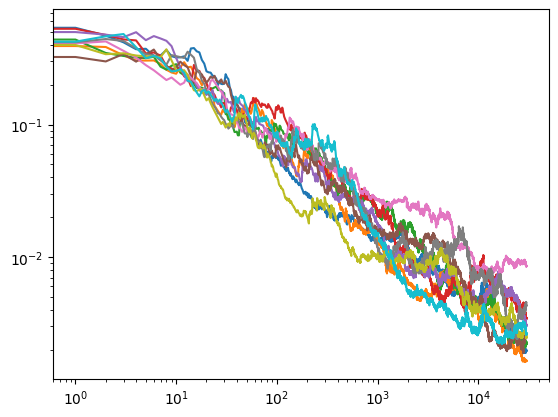

In [14]:
# Load data from QST_settings.npy
base_path = "results/2023-12-01_11-32-15_a1982a66-4157-4e19-92a0-01604bb3b317/"
qst = QST.load_data(base_path)


# You can perform BME with the uncorrected POVM (default setting: Pauli-6)
qst.perform_BME()
uncorrected_infidelity = qst.get_infidelity()


# Perform BME with corrected POVM
use_corrected_POVM = True
qst.perform_BME(use_corrected_POVM)
corrected_infidelity = qst.get_infidelity()


for i in range (len(uncorrected_infidelity)):
    plt.plot(uncorrected_infidelity[i])
    plt.plot(corrected_infidelity[i])
plt.yscale('log')
plt.xscale('log')
plt.show()


Example of loading results directly from QST_results.npy

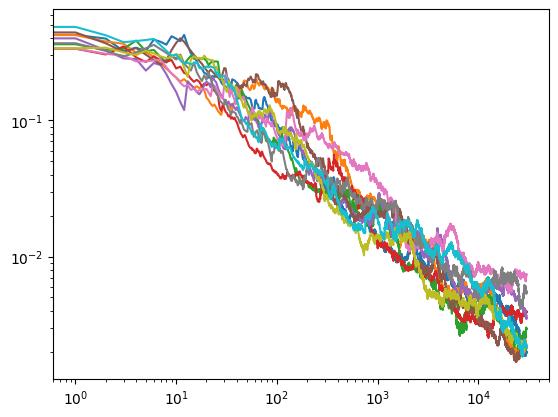

In [17]:
base_path = "results/2023-12-01_11-32-15_a1982a66-4157-4e19-92a0-01604bb3b317/"

# The data is saved in the following order
with open(f'{base_path}/QST_results.npy','rb') as f:
    corrected_infidelity = np.load(f)
    uncorrected_infidelity = np.load(f)
    uncorrected_rho_est = np.load(f)
    corrected_rho_estm = np.load(f)
    
for i in range (len(uncorrected_infidelity)):
    plt.plot(uncorrected_infidelity[i])
    plt.plot(corrected_infidelity[i])
plt.yscale('log')
plt.xscale('log')
plt.show()
